In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import importlib
import ssm
from ssm.plots import plot_dynamics_2d
from sklearn.decomposition import PCA

import classes as cl
import utils

In [2]:
# Reloads custom modules so that we can test them quickly without having to rerun the whole notebook
importlib.reload(cl)
importlib.reload(utils)

<module 'utils' from '/Users/sean/Documents/Personal/Education/Grad School/Research/Ganguli/git/neuro-control/utils.py'>

# Setup
The dynamics of the teacher is
$$\tau\dot{\mathbf{z}}=-\mathbf{z}+B\mathbf{z}+\xi(t)$$
and the dynamics of the student is
$$\tau\dot{\mathbf{x}}=-\mathbf{x}+A\mathbf{x}+\boldsymbol{\eta}(t).$$
In discrete simulations, we follow the paper and use Euler integration. The discretization of the teacher is:
$$\mathbf{z}_t=(1-\alpha)\mathbf{z}_{t-1}+\alpha B\phi(\mathbf{z}_{t-1})+\sqrt{2\alpha}\xi_t,$$
where $\phi$ is a possibly nonlinear transfer function (=id for the linear case). $\textcolor{red}{\text{Why }\sqrt{2\alpha}?}$


In [3]:
# Parameters
tau = 1
D_t = 500 # Teacher network size
D_s = 25 # Student network size
dt = 0.01
#sigma_student = 0
#sigma_teacher = 0
sigma_student = 0.02 / np.sqrt(2) # Standard deviation of the student's noise
sigma_teacher = 0.02 / np.sqrt(2) # Standard deviation of the teacher's noise
T = 30000
alpha = dt / tau # Discretization time scale

obs_idx = np.arange(D_s) # For simplicity, we will observe the first D_s neurons

# Parameters for LDS
init_T = 5

In [4]:
# Create the recurrence matrix. (See Appendix A of the paper for details)
eigenvals = np.zeros(D_t)
eigenvals[0] = 1 - 1e-3
eigenvals[1:] = 0.2
Q = np.random.randn(D_t, D_t) * np.sqrt(1 / D_t)
J = Q @ np.diag(eigenvals) @ np.linalg.inv(Q)

In [5]:
rnn = cl.RNN(n_rec=D_t, n_in=0, alpha=alpha, sigma_rec=sigma_teacher, w_in=None, w_rec=J, phi=None)
r_all = rnn.forecast(T = T)
observations = r_all[:, obs_idx] # Observe D_s neurons
inputs = np.ones((T, 2)) # Constant input

In [6]:
# Make a simple forecast function based on our rnn
def forecast_gt(T, r_in):
    r_all = rnn.forecast(r_in = r_in, T = T)
    return r_all

# LDS Model
Now, we fit an LDS model to learn the dynamics.

In [7]:
# Train an LDS to learn the dynamics
# https://github.com/lindermanlab/ssm/tree/master
#obs_idx = np.random.choice(D_t, D_s, replace=False) # Important! No replacement.

obs_dim = observations.shape[1]
state_dim = 10
num_iters = 10
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos_train, q = lds.fit(observations, method="laplace_em", num_iters=num_iters)

# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, observations)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# Predict with the model
y_init_train = observations[0:init_T,:]

elbos_pred, r_pred = utils.sample_slds(lds, y_init_train, T) # Smoothed emissions

# Now, make graphs of the eigenvalues and attractor structure
# First, get the parameters of the dynamics.
lds.params[2]
# A, b, V, sqrt sigmas (for Gaussian)
A = lds.params[2][0]
eigenvals_pred = np.linalg.eigvals(A)

  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


In [9]:
# Make a simple forecast function based on our lds model
def forecast_pred(T, r_in):
    if r_in is None:
        #TODO: Change this to random initial conditions, becasue we don't need consistency with gt for attractor visualization
        r_in = rnn.forecast(T = init_T)[:, obs_idx] # Generate random initial conditions consistent with gt
    _, r_pred = utils.sample_slds(lds, r_in, T)
    return r_pred

In [10]:
# Now, let's try on a test trial.
r_all_test = rnn.forecast(T = T)
observations_test = r_all_test[:, obs_idx]
y_init_test = observations_test[0:init_T,:]

elbos_pred_test, r_pred_test = utils.sample_slds(lds, y_init_test, T) # Smoothed emissions

  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


ELBOs of training plotted in 0.06 seconds
ELBOs of forecasting on the training set plotted in 0.03 seconds
Ground truth firing rates for the training set plotted in 0.60 seconds
Prediction firing rates for the training set plotted in 0.10 seconds
Ground truth distribution for the training set plotted in 0.04 seconds
Firing rates comparison for the training set plotted in 0.10 seconds
Normalized residuals for the training set plotted in 0.36 seconds
Unnormalized residuals for the training set plotted in 0.41 seconds
Neurons comparison for the training set plotted in 0.70 seconds
Spectrum comparison plotted in 0.03 seconds
Dynamics of ground truth plotted in 37.17 seconds


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)


  0%|          | 0/50 [00:00<?, ?it/s]

x_init_test has shape: (5, 10)
Dynamics of prediction plotted in 20.75 seconds
ELBOs of forecasting on the test set plotted in 0.03 seconds
Ground truth firing rates for the test set plotted in 0.61 seconds
Prediction firing rates for the test set plotted in 0.06 seconds
Ground truth distribution for the test set plotted in 0.04 seconds
Firing rates comparison for the test set plotted in 0.10 seconds
Normalized residuals for the test set plotted in 0.34 seconds
Unnormalized residuals for the test set plotted in 0.32 seconds
Neurons comparison for the test set plotted in 0.69 seconds


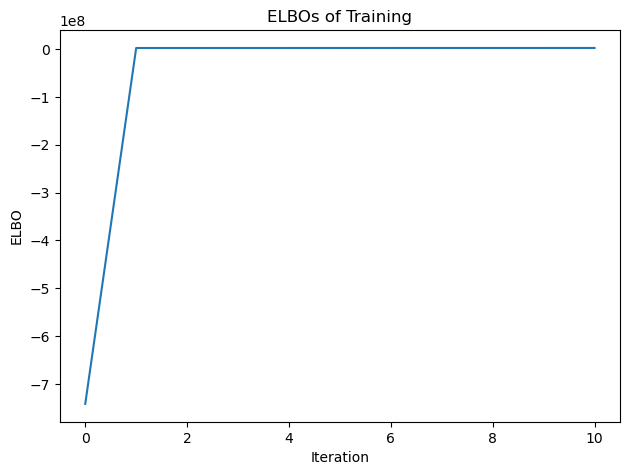

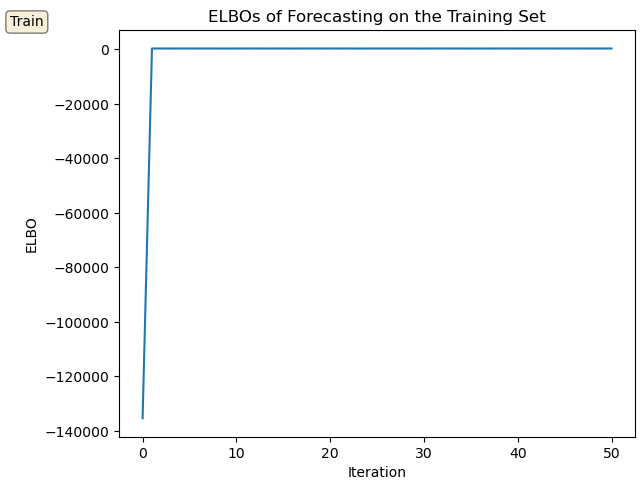

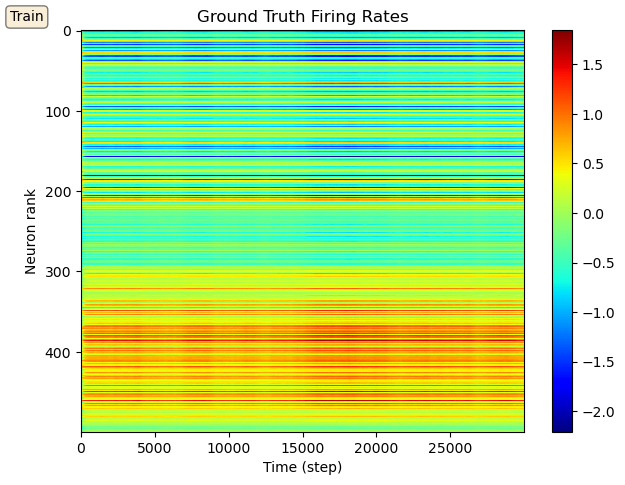

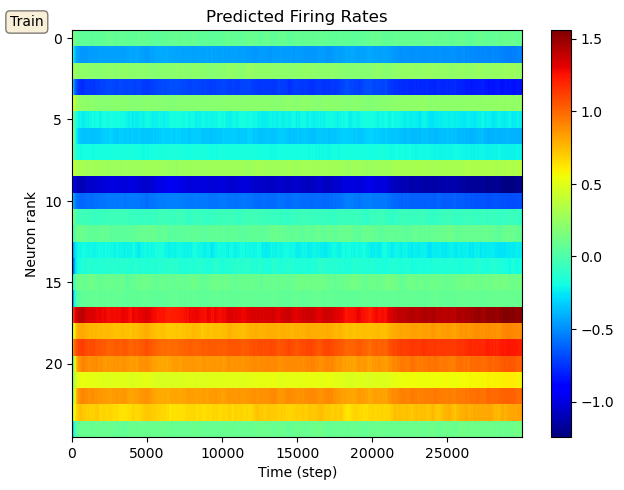

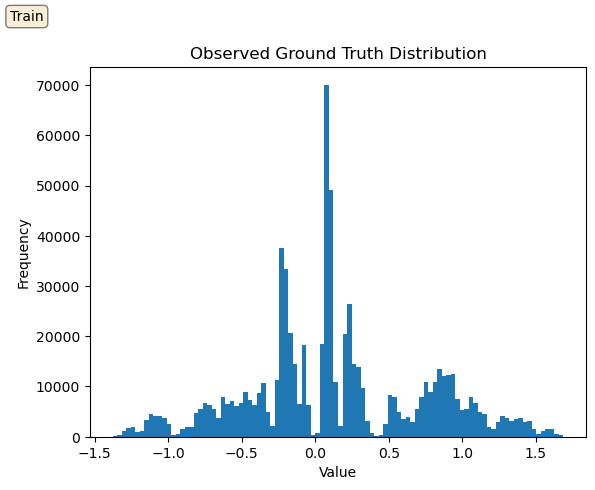

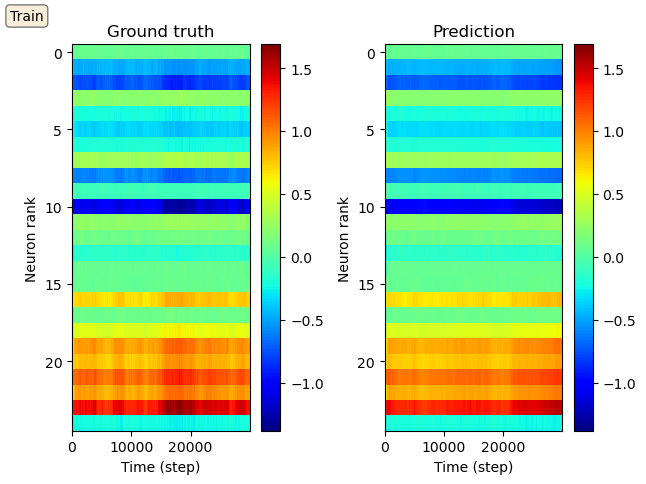

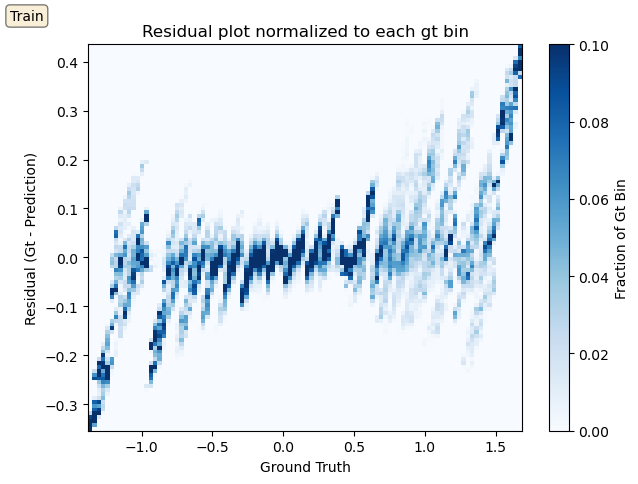

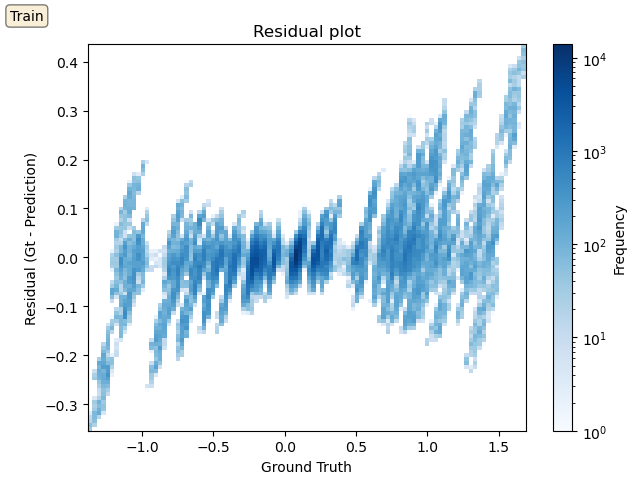

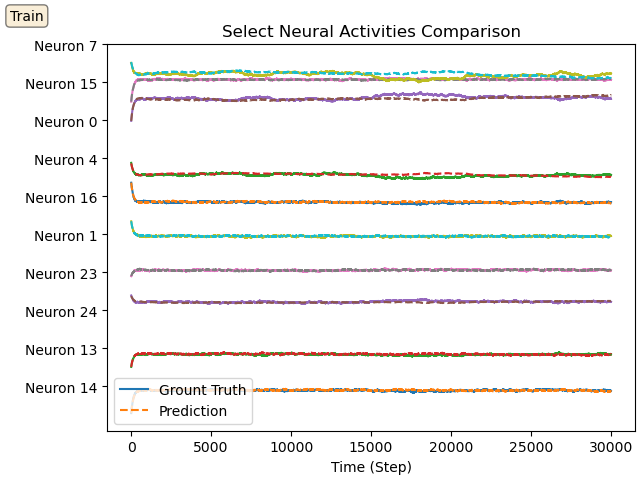

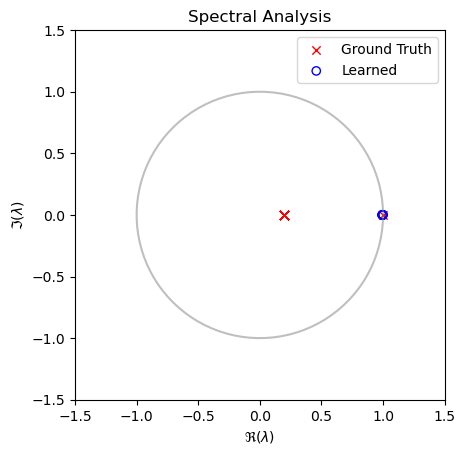

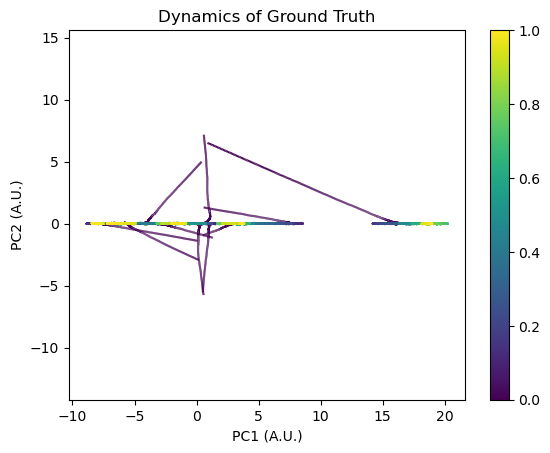

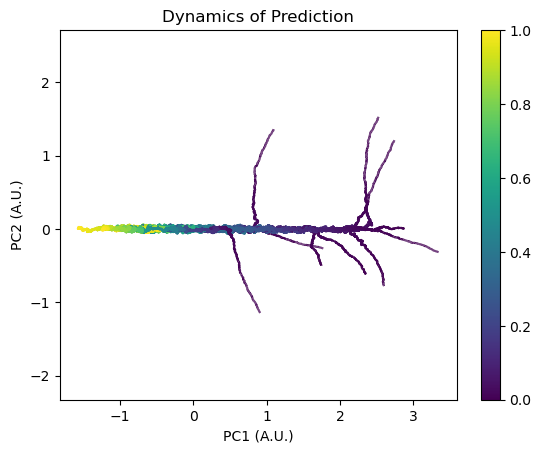

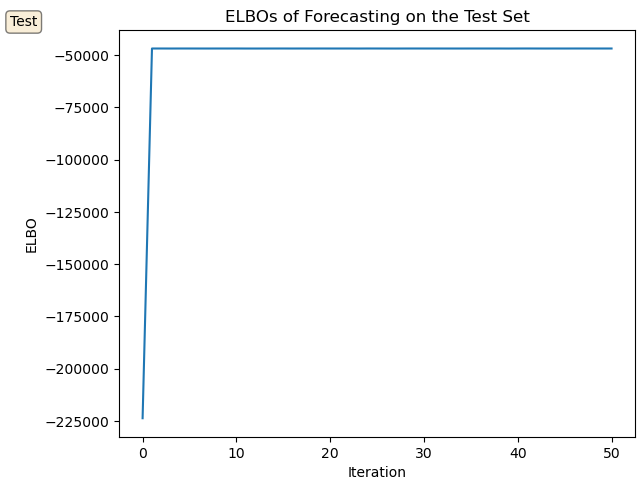

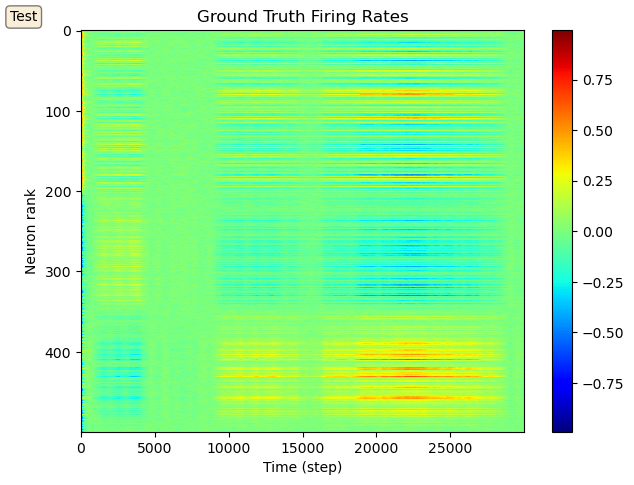

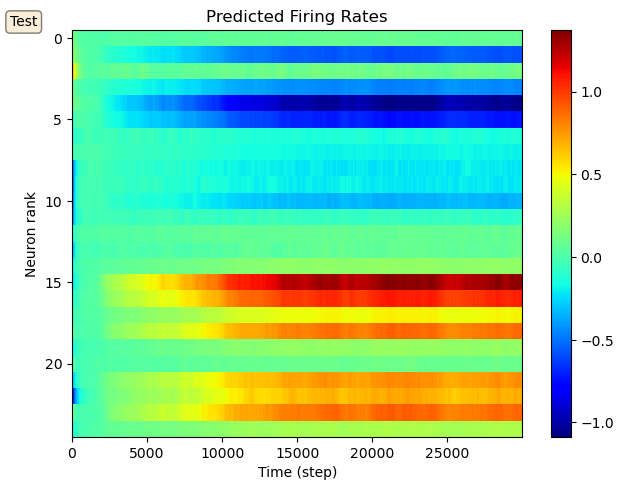

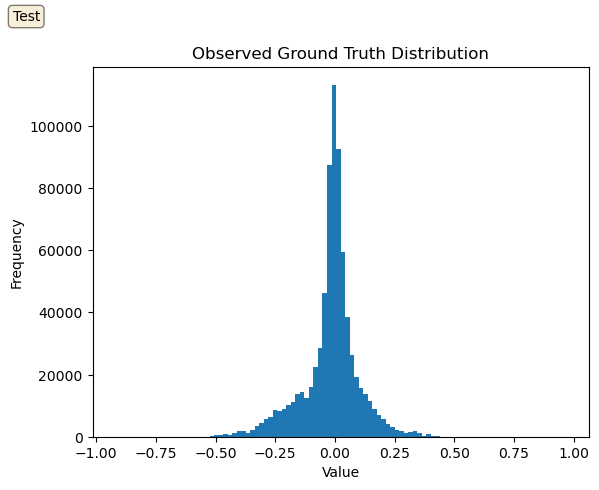

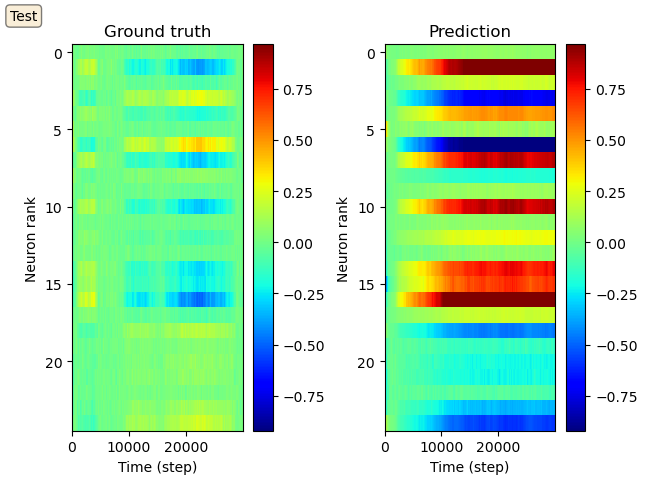

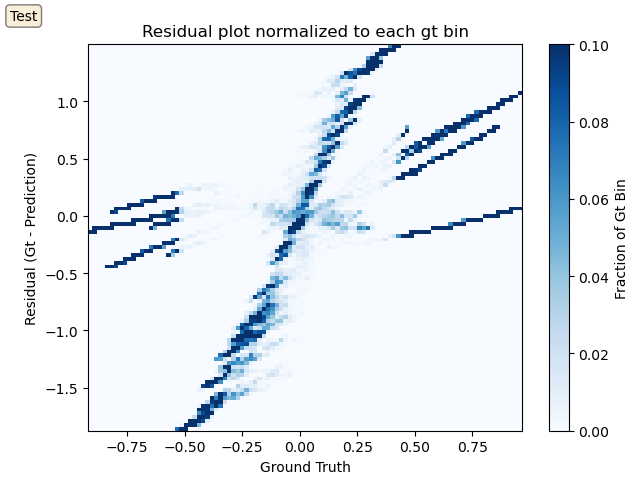

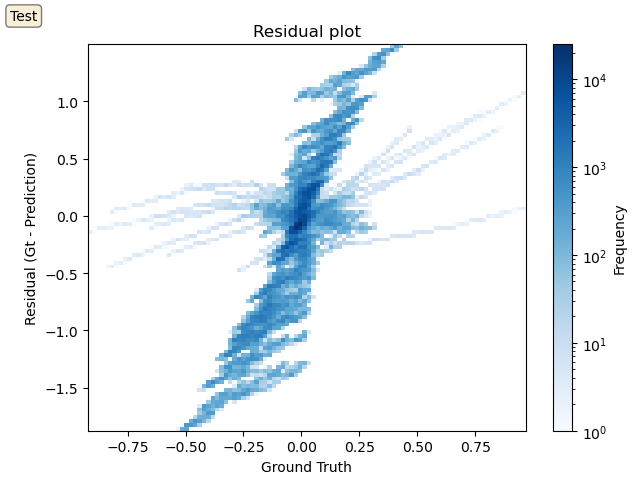

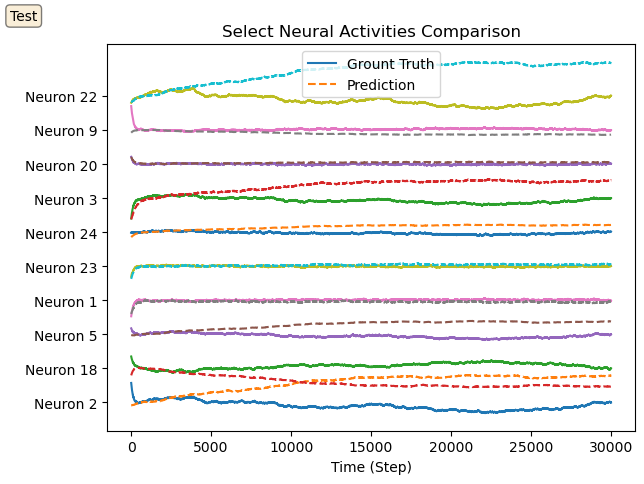

In [11]:
# Plot all the graphs
g = cl.Graphs(r_gt_all_train = r_all, r_gt_all_test = r_all_test, r_gt_obs_train = observations, r_gt_obs_test = observations_test, r_pred_train = r_pred, r_pred_test = r_pred_test, elbos_train = elbos_train, elbos_pred_train = elbos_pred, elbos_pred_test = elbos_pred_test, eigenvals_gt = eigenvals, eigenvals_pred = eigenvals_pred, forecast_gt=forecast_gt, forecast_pred=forecast_pred)
g.plot_all()


# MAP estimate
Now, we try using MAP to fit the dynamical system. First, we have the projection matrix:
$$P=(I_d,\ 0_{d\times(D-d)}) \in \mathbb{R}^{d\times D}.$$

In [12]:
P = np.zeros((D_s, D_t))
P[:, obs_idx] = np.eye(D_s)

## Infinite Time
In the long time limit, we have
$$\hat{A}_\infty=PBSP^\top\left(PSP^\top+\rho I_d\right)^{-1},$$
where $\rho$ is a regularization parameter on the norm of $A$, $B$ is the teacher dynamics matrix, and $S$ is the equal time covariance matrix that given by the Lyapunov equation
$$(I_D-B)S+S(I_D-B)=2\sigma_\xi^2I_D.$$

In [13]:
rho = 0
S = sp.linalg.solve_sylvester(np.eye(D_t)-J, np.eye(D_t)-J, 2*sigma_teacher**2 * np.eye(D_t))
A_hat_inf = P @ J @ S @ P.T @ np.linalg.inv(P @ S @ P.T + rho*np.eye(D_s))

In [14]:
(np.eye(D_t)-J) @ S + S @ (np.eye(D_t)-J) - 2*sigma_teacher**2 * np.eye(D_t)

array([[-7.75204553e-18, -1.38901545e-16,  5.41084647e-18, ...,
        -5.19061790e-18, -9.10729825e-18, -1.27935856e-17],
       [-1.35339983e-16,  3.65376132e-17,  1.77796874e-16, ...,
        -1.24143266e-16,  8.19860130e-17, -1.74329121e-16],
       [ 9.16150836e-18, -1.92544988e-16, -2.27682456e-18, ...,
        -4.68917440e-18, -2.61902587e-18, -8.07730619e-18],
       ...,
       [ 5.28972076e-19, -1.73472348e-17, -1.03083910e-18, ...,
        -1.13841228e-18,  0.00000000e+00,  1.73472348e-18],
       [-7.97396817e-18, -7.44249734e-17,  7.57925081e-18, ...,
        -6.93889390e-18,  1.57209315e-18, -9.97465999e-18],
       [ 2.70034104e-18,  1.00421685e-16,  1.48400172e-18, ...,
         7.80625564e-18, -1.73472348e-18, -1.46367293e-18]])

In [15]:
S

array([[ 0.00690633, -0.00114259, -0.00872784, ...,  0.00615614,
        -0.00402474,  0.00861427],
       [-0.00060306,  0.00035352,  0.00079074, ..., -0.00055775,
         0.00036464, -0.00078045],
       [ 0.00913587, -0.00156822, -0.01172906, ...,  0.00844936,
        -0.005524  ,  0.01182317],
       ...,
       [ 0.00082172, -0.00014105, -0.00107744, ...,  0.00100997,
        -0.00049685,  0.00106342],
       [ 0.00355551, -0.00061032, -0.00466202, ...,  0.00328833,
        -0.00189984,  0.00460135],
       [-0.00482024,  0.00082742,  0.00632035, ..., -0.00445802,
         0.00291456, -0.0059881 ]])

In [16]:
# Make predictions on the training and test trials
y_init_train = observations[0,:]
rnn_pred = cl.RNN(n_rec=D_s, n_in=0, alpha=alpha, sigma_rec=0, w_in=None, w_rec=A_hat_inf, phi=None)
r_pred = rnn_pred.forecast(r_in=y_init_train, T = T)
eigenvals_pred = np.linalg.eigvals(A_hat_inf)

In [17]:
# Now, let's try on a test trial.
r_all_test = rnn.forecast(T = T)
observations_test = r_all_test[:, obs_idx]
y_init_test = observations_test[0,:]

r_pred_test = rnn_pred.forecast(r_in=y_init_test, T = T)

In [18]:
# Make a simple forecast function based on our MAP estimate
def forecast_pred(T, r_in):
    r_pred = rnn_pred.forecast(r_in = r_in, T = T)
    return r_pred

Ground truth firing rates for the training set plotted in 0.62 seconds
Prediction firing rates for the training set plotted in 0.07 seconds
Ground truth distribution for the training set plotted in 0.04 seconds
Firing rates comparison for the training set plotted in 0.10 seconds
Normalized residuals for the training set plotted in 0.33 seconds
Unnormalized residuals for the training set plotted in 0.31 seconds
Neurons comparison for the training set plotted in 0.66 seconds
Spectrum comparison plotted in 0.02 seconds
Dynamics of ground truth plotted in 37.74 seconds
Dynamics of prediction plotted in 7.76 seconds
Ground truth firing rates for the test set plotted in 0.63 seconds
Prediction firing rates for the test set plotted in 0.07 seconds
Ground truth distribution for the test set plotted in 0.04 seconds
Firing rates comparison for the test set plotted in 0.10 seconds
Normalized residuals for the test set plotted in 0.34 seconds
Unnormalized residuals for the test set plotted in 0.41

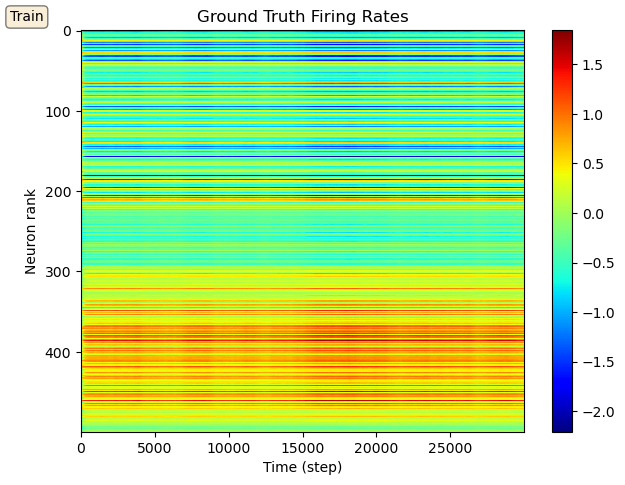

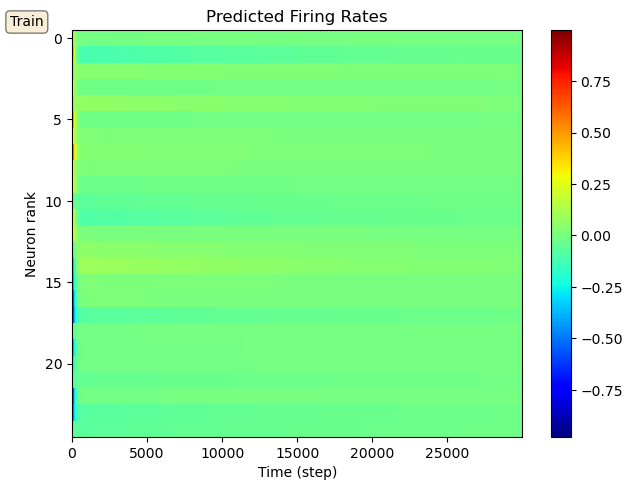

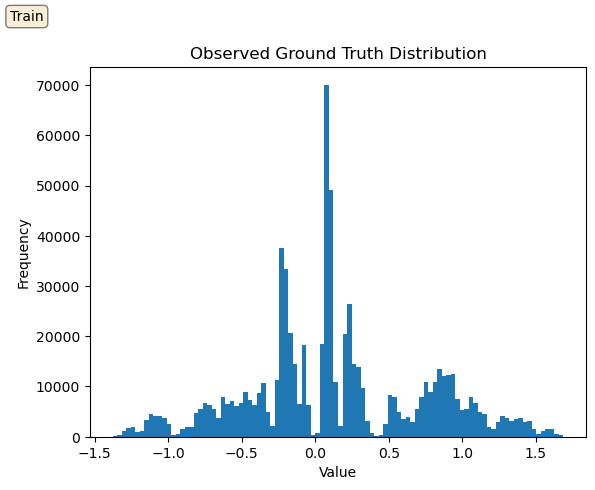

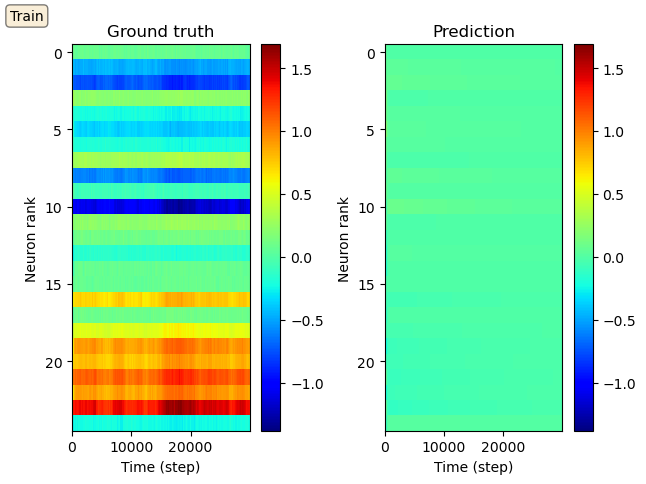

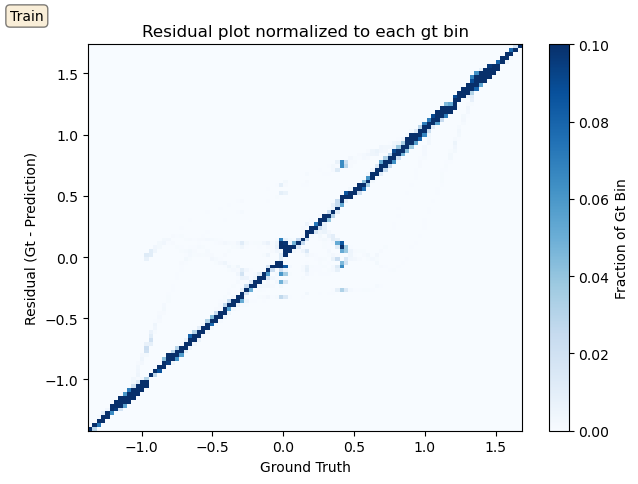

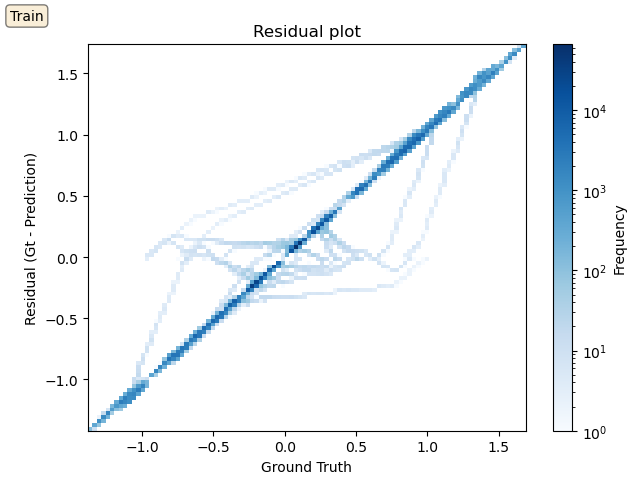

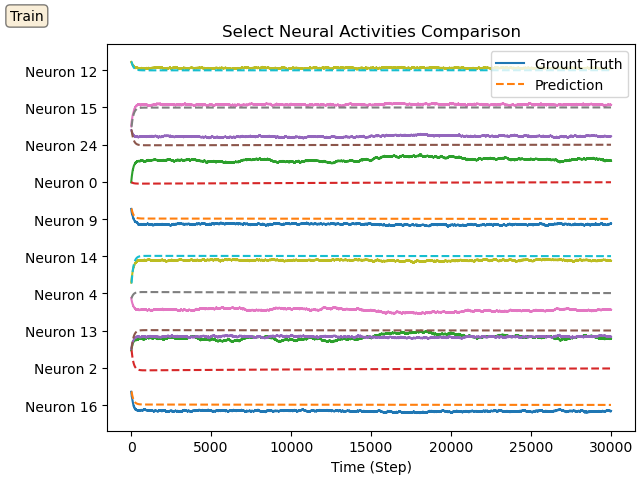

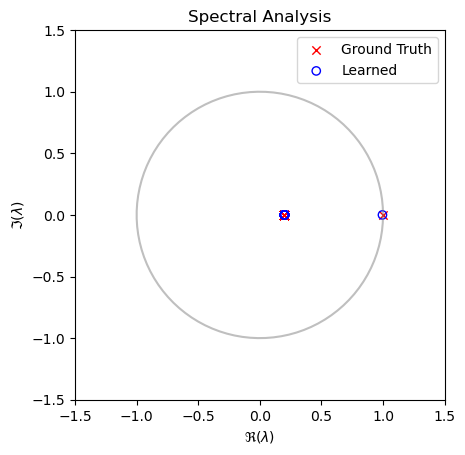

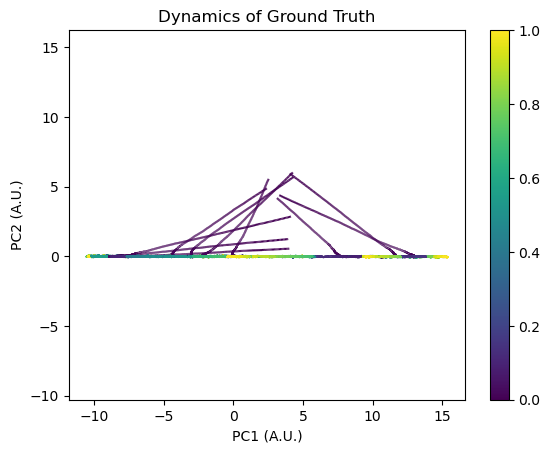

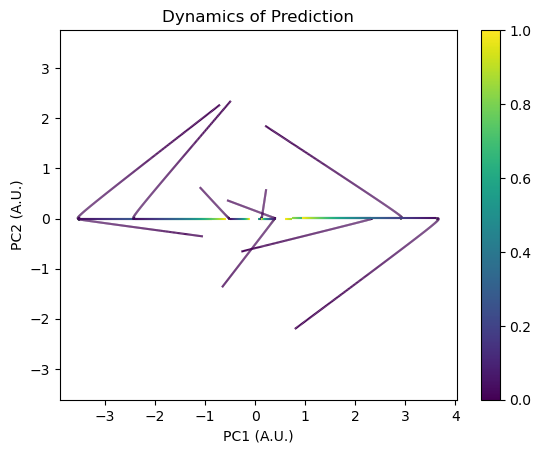

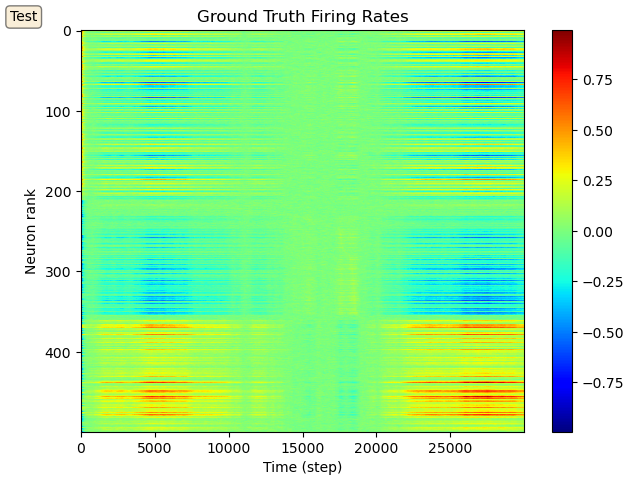

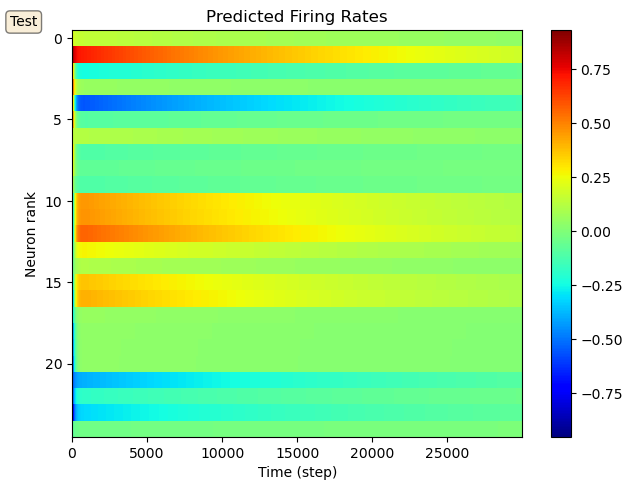

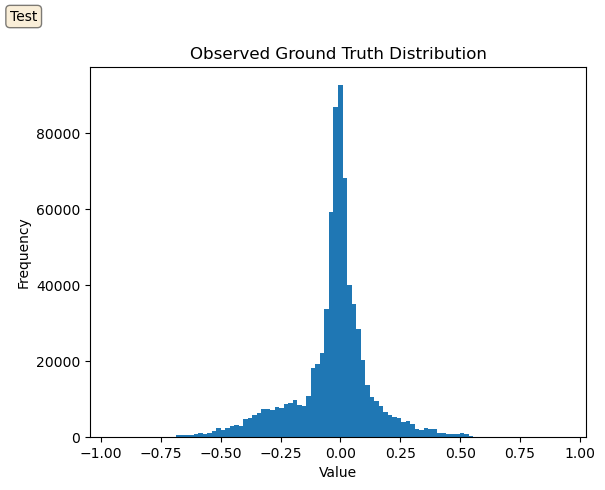

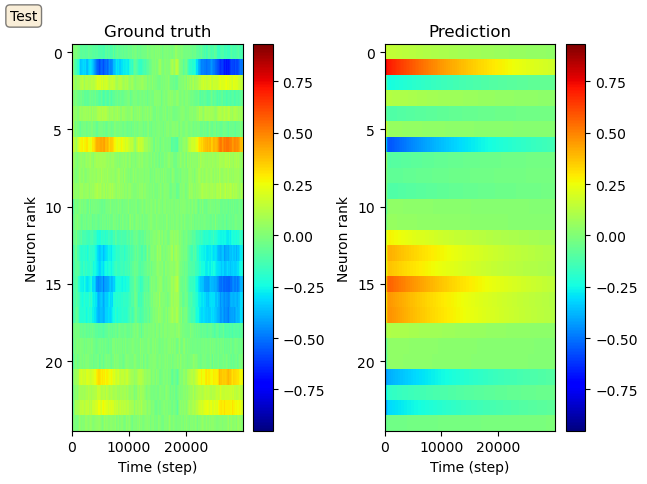

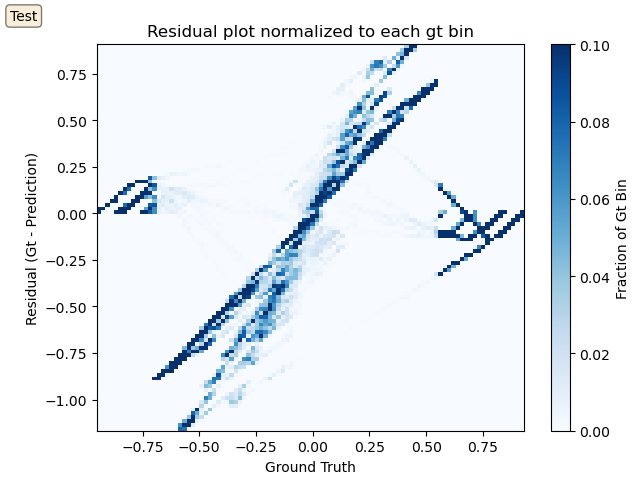

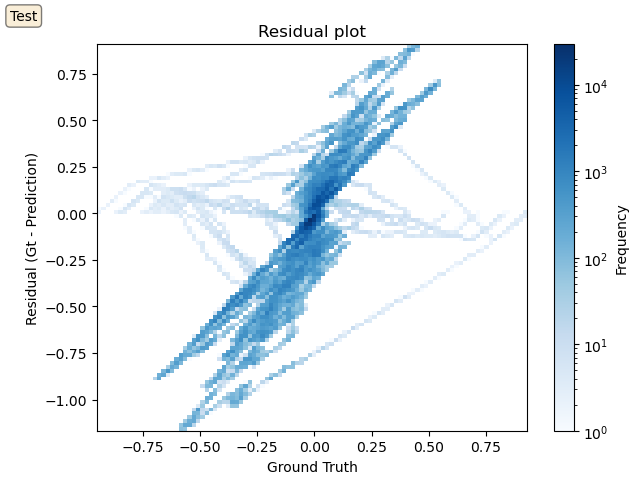

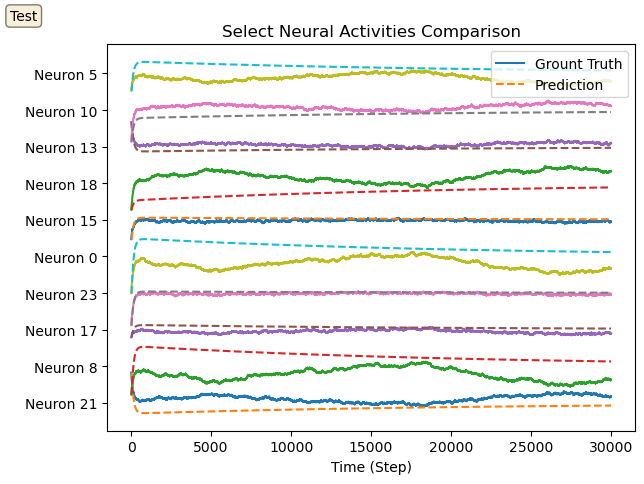

In [19]:
# Plot all the graphs for the training trial
g = cl.Graphs(r_gt_all_train = r_all, r_gt_all_test = r_all_test, r_gt_obs_train = observations, r_gt_obs_test = observations_test, r_pred_train = r_pred, r_pred_test = r_pred_test, eigenvals_gt = eigenvals, eigenvals_pred = eigenvals_pred, forecast_gt=forecast_gt, forecast_pred=forecast_pred)
g.plot_all()


In [20]:
#plt.hist(J.flatten(), bins=100)

In [21]:
#plt.hist(A_hat_inf.flatten(), bins=100)

In [22]:
#plt.hist((J-A_hat_inf).flatten(), bins=100)

## Finite Time
In the finite time case, we have
$$\hat{A}_T=\alpha^2P\left(BC_T+\frac1T\sum_{t=1}^T\xi_t\phi(\mathbf{z}_{t-1})^\top\right)P^\top\left(\rho I_d+\alpha^2PC_TP^\top\right)^{-1},$$
where
$$C_T=\frac{1}{T}\sum_{t=1}^T\phi(\mathbf{z}_{t-1})\phi(\mathbf{z}_{t-1})^\top.$$
This is written in terms of the teacher network. But to apply it to real data, we want to only use the observations. So we have
$$\hat{A}_T=\alpha\left(\frac1T\sum_{t=1}^T(\mathbf{x}_t^o-(1-\alpha)\mathbf{x}_{t-1}^o)\phi(\mathbf{x}_{t-1}^o)^\top\right)\left(\rho I+\alpha^2\frac1T\sum_{t=1}^T\phi(\mathbf{x}_{t-1}^o)\phi(\mathbf{x}_{t-1}^o)^\top\right)^{-1}.$$

In [23]:
rho = 0
A_hat_T = utils.finite_MAP(alpha, T, observations, lambda x:x, rho)

In [24]:
# Make predictions on the training and test trials
y_init_train = observations[0,:]
rnn_pred = cl.RNN(n_rec=D_s, n_in=0, alpha=alpha, sigma_rec=0, w_in=None, w_rec=A_hat_T, phi=None)
r_pred = rnn_pred.forecast(r_in=y_init_train, T = T)
eigenvals_pred = np.linalg.eigvals(A_hat_T)

In [25]:
# Now, let's try on a test trial.
r_all_test = rnn.forecast(T = T)
observations_test = r_all_test[:, obs_idx]
y_init_test = observations_test[0,:]

r_pred_test = rnn_pred.forecast(r_in=y_init_test, T = T)

In [26]:
# Make a simple forecast function based on our MAP estimate
def forecast_pred(T, r_in):
    r_pred = rnn_pred.forecast(r_in = r_in, T = T)
    return r_pred

Ground truth firing rates for the training set plotted in 0.63 seconds
Prediction firing rates for the training set plotted in 0.06 seconds
Ground truth distribution for the training set plotted in 0.05 seconds
Firing rates comparison for the training set plotted in 0.11 seconds
Normalized residuals for the training set plotted in 0.35 seconds
Unnormalized residuals for the training set plotted in 0.33 seconds
Neurons comparison for the training set plotted in 0.65 seconds
Spectrum comparison plotted in 0.02 seconds
Dynamics of ground truth plotted in 37.75 seconds
Dynamics of prediction plotted in 7.76 seconds
Ground truth firing rates for the test set plotted in 0.64 seconds
Prediction firing rates for the test set plotted in 0.07 seconds
Ground truth distribution for the test set plotted in 0.04 seconds
Firing rates comparison for the test set plotted in 0.11 seconds
Normalized residuals for the test set plotted in 0.46 seconds
Unnormalized residuals for the test set plotted in 0.33

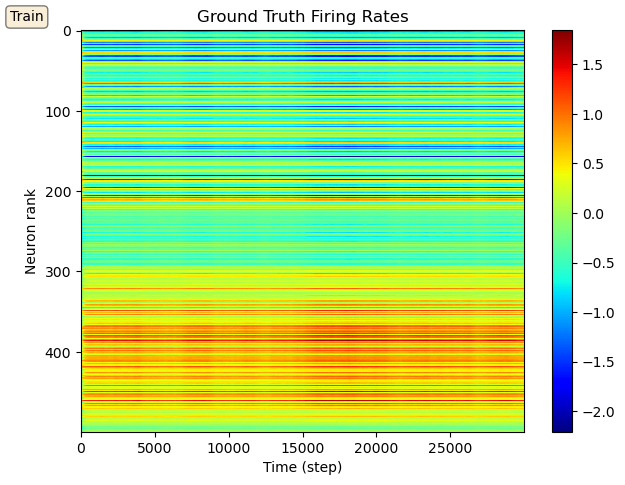

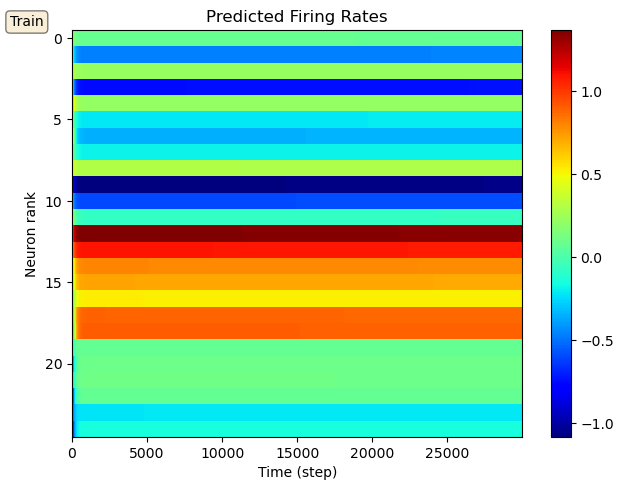

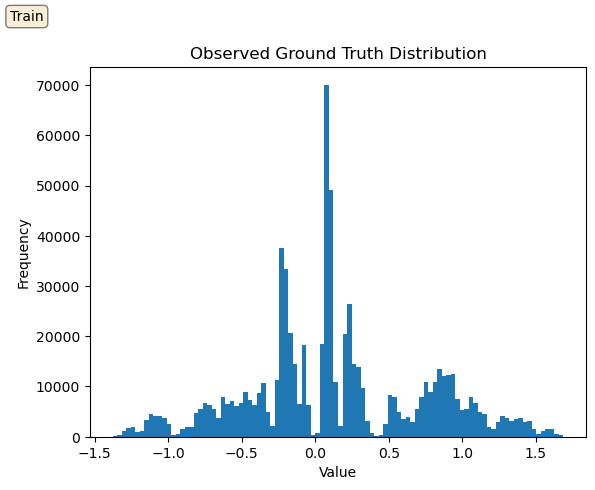

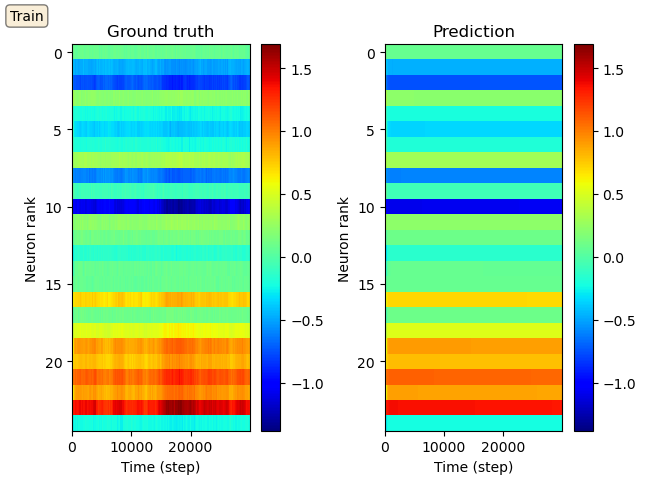

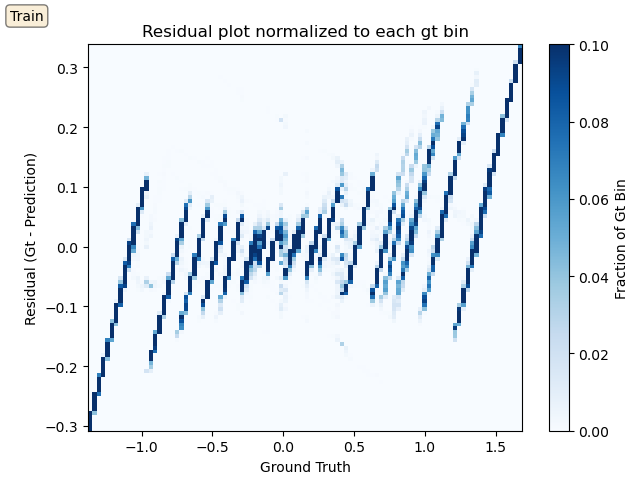

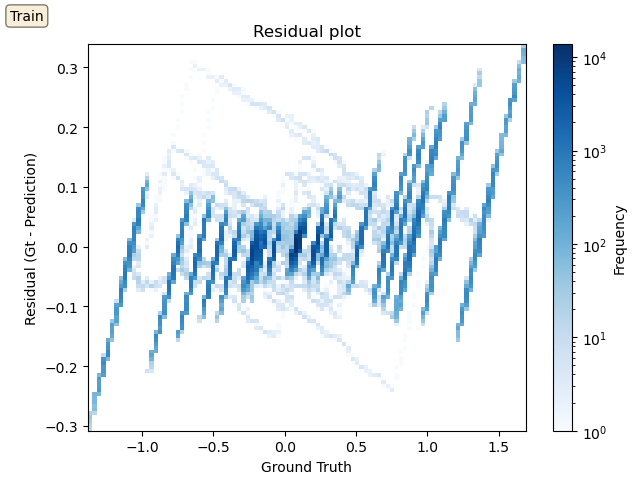

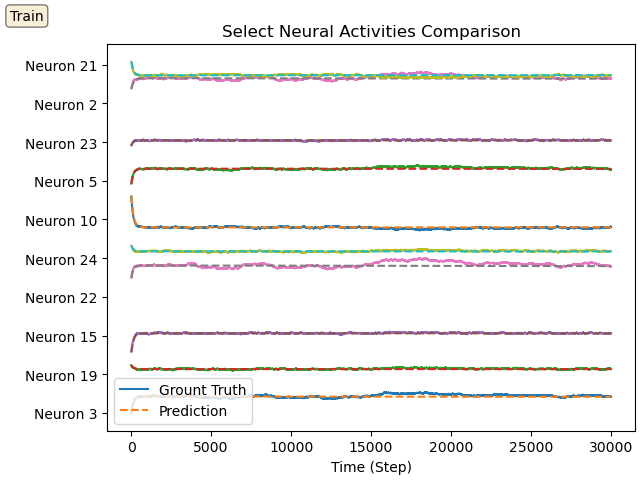

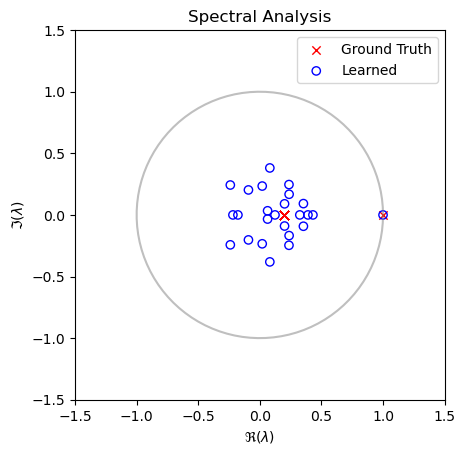

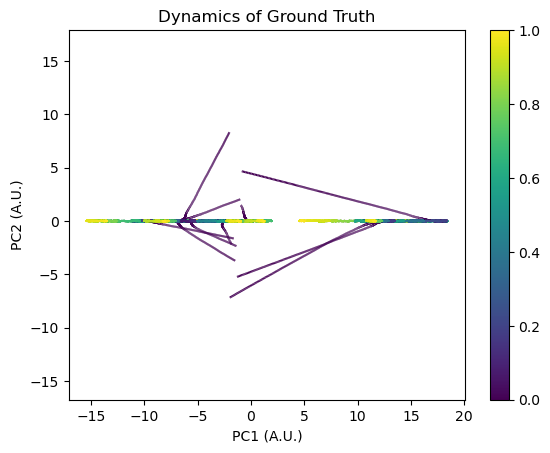

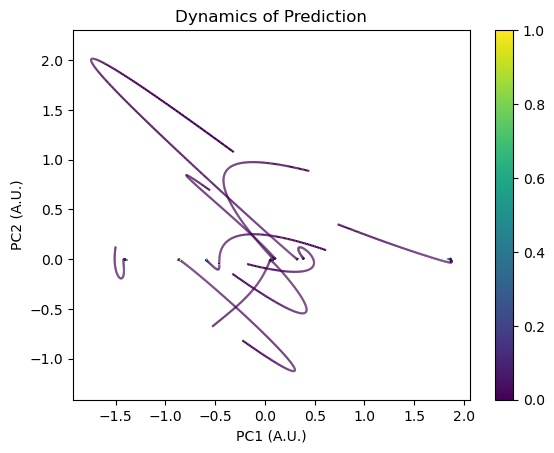

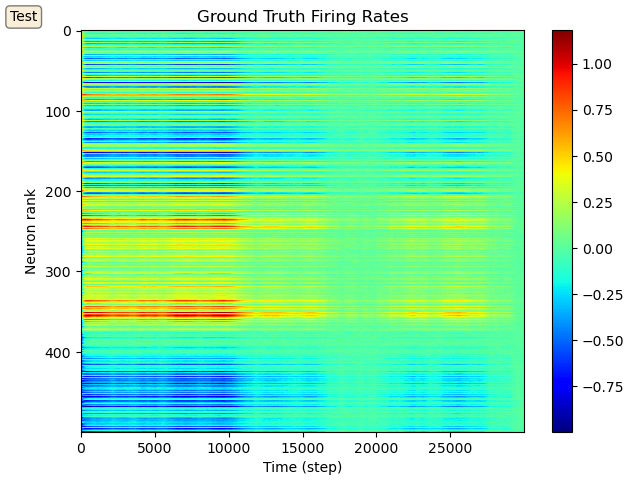

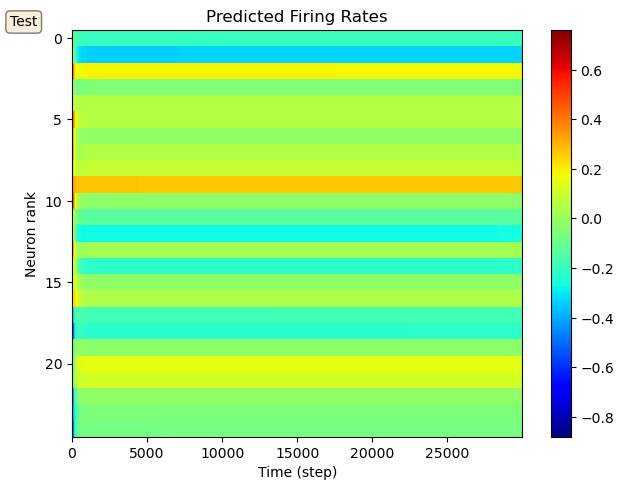

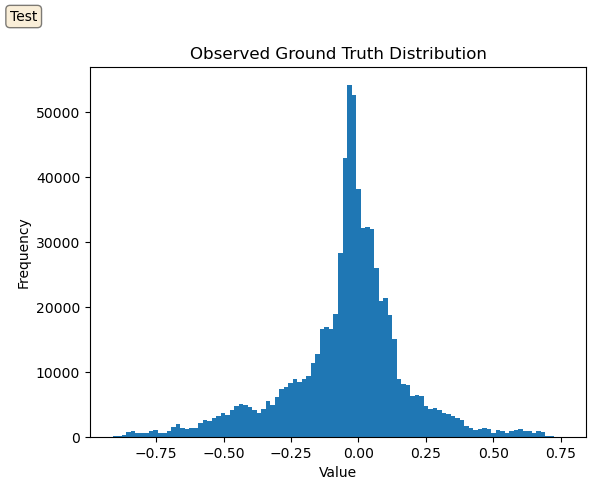

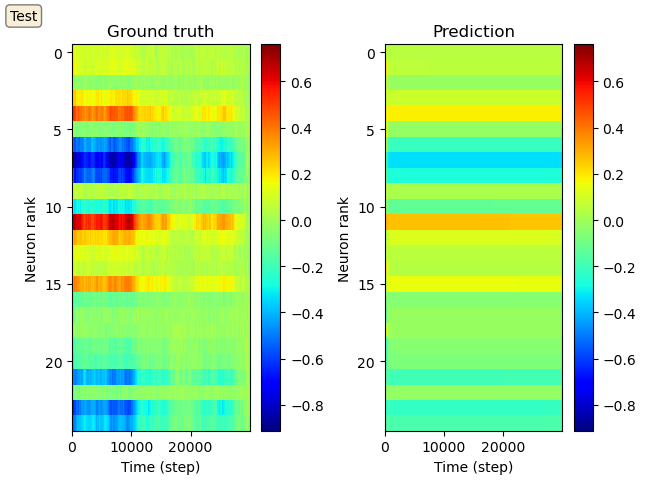

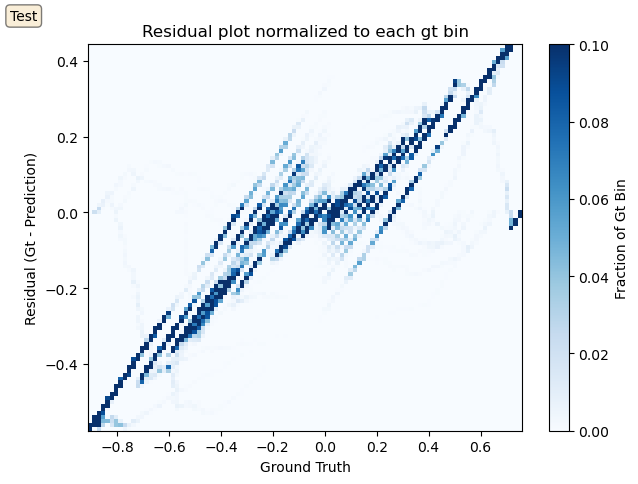

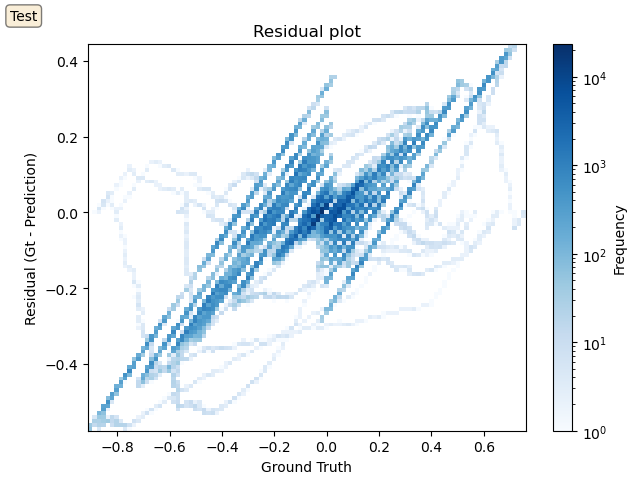

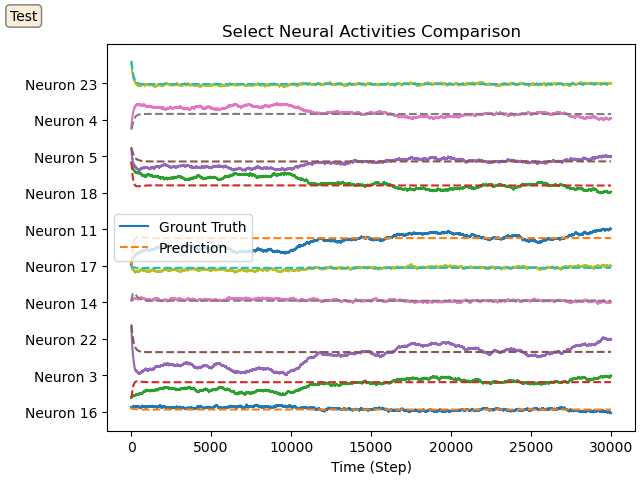

In [27]:
# Plot all the graphs for the training trial
g = cl.Graphs(r_gt_all_train = r_all, r_gt_all_test = r_all_test, r_gt_obs_train = observations, r_gt_obs_test = observations_test, r_pred_train = r_pred, r_pred_test = r_pred_test, eigenvals_gt = eigenvals, eigenvals_pred = eigenvals_pred, forecast_gt=forecast_gt, forecast_pred=forecast_pred)
g.plot_all()


# Figure 4
Then, we try to reproduce Figure 4, which shows spurious line attractors learned from low-rank non-normal teacher.